In [3]:
import pandas as pd
import torchvision
import torch
from torchvision import transforms, models
import cv2

import os
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import glob
import antialiased_cnns
import nonechucks as nc
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
model_name = 'resnet152'
num_epochs = 100
model_odir = f'trained_models/{model_name}'

princess_dataset_labelled = '/home/tesla/tigers_bbox/princess_task_data'
print('model_name:', model_name)

model = antialiased_cnns.resnet152(pretrained=True).to(device)

model.eval()
for param in model.parameters():
    param.requires_grad = False
model._modules.get('avgpool')
print('device:', device)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize
        ]),
    'validation':
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            normalize
        ]),
}

image_datasets = {
    'train':
        nc.SafeDataset(
            torchvision.datasets.ImageFolder('%s/train' % princess_dataset_labelled,
                                             data_transforms['train'])),
    'validation':
        nc.SafeDataset(
            torchvision.datasets.ImageFolder('%s/val' % princess_dataset_labelled,
                                             data_transforms['validation']))
}

dataloaders = {
    'train':
        torch.utils.data.DataLoader(image_datasets['train'],
                                    batch_size=32,
                                    shuffle=True,
                                    num_workers=0,
                                    ),
    'validation':
        torch.utils.data.DataLoader(image_datasets['validation'],
                                    batch_size=32,
                                    shuffle=False,
                                    num_workers=0
                                    )
}

print('model_odir', model_odir)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters())

model_name: resnet152
device: cuda:0
model_odir trained_models/resnet152


In [5]:
%%time
odir = f'trained_models/{model_name}'

lines = []
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 40)
    
    
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        
        running_loss = 0.0
        running_corrects = 0

        pred_phase = []
        y_true_phase = []
        y_pred_prob = []

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            pred_phase += list(preds.data.cpu().numpy())
            y_true_phase += list(labels.data.cpu().numpy())
            

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = float(running_corrects.double() / len(image_datasets[phase]))

        f1_s = f1_score(y_true_phase, pred_phase)
        line = dict(epoch=epoch, epoch_loss=epoch_loss, epoch_acc=epoch_acc,
                    f1=f1_s, phase=phase
                   )
        lines.append(line)

        print('{} loss: {:.4f}, acc: {:.4f} f1: {:.4f}'.format(phase,
                                                    epoch_loss,
                                                    epoch_acc,   
                                                    f1_s
                                                   ))
    os.makedirs(odir, exist_ok=True)
    
    if epoch % 3 == 0 and epoch > 10:
        torch.save(model.state_dict(), f'{odir}/weights_epoch_{epoch}.h5')

Epoch 1/100
----------------------------------------
train loss: 0.2814, acc: 0.9115 f1: 0.0329
validation loss: 0.2401, acc: 0.9238 f1: 0.1553
Epoch 2/100
----------------------------------------
train loss: 0.2077, acc: 0.9194 f1: 0.1371
validation loss: 0.2158, acc: 0.9203 f1: 0.0808
Epoch 3/100
----------------------------------------
train loss: 0.1978, acc: 0.9235 f1: 0.2039
validation loss: 0.2082, acc: 0.9168 f1: 0.0000
Epoch 4/100
----------------------------------------
train loss: 0.1971, acc: 0.9198 f1: 0.1712
validation loss: 0.2249, acc: 0.9168 f1: 0.0000
Epoch 5/100
----------------------------------------
train loss: 0.1823, acc: 0.9247 f1: 0.2593
validation loss: 0.1799, acc: 0.9229 f1: 0.1373
Epoch 6/100
----------------------------------------
train loss: 0.1639, acc: 0.9333 f1: 0.3746
validation loss: 0.1728, acc: 0.9317 f1: 0.3158
Epoch 7/100
----------------------------------------
train loss: 0.1685, acc: 0.9288 f1: 0.3127
validation loss: 0.2143, acc: 0.9168 f1:

RuntimeError: [enforce fail at inline_container.cc:300] . unexpected pos 122992576 vs 122992472

In [19]:
! ls trained_models/resnet152/weights_epoch_63.h5

trained_models/resnet152/weights_epoch_63.h5


In [1]:
scores = pd.DataFrame(lines)

import matplotlib.pyplot as plt

plt.figure()
scores.query('phase == "train"')['f1'].plot(ax=plt.gca(), label='train')
scores.query('phase == "validation"')['f1'].plot(ax=plt.gca(), label='val')
plt.title(f'resnet152 {epoch} f1')
plt.legend()
plt.show();

NameError: name 'pd' is not defined

In [23]:
! /home/tesla/tigers_bbox/trained_models/

/home/tesla/tigers_bbox


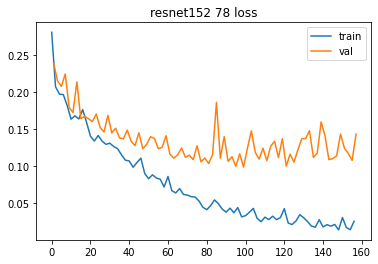

In [22]:
scores = pd.DataFrame(lines)

import matplotlib.pyplot as plt

plt.figure()
scores.query('phase == "train"')['epoch_loss'].plot(ax=plt.gca(), label='train')
scores.query('phase == "validation"')['epoch_loss'].plot(ax=plt.gca(), label='val')
plt.title(f'resnet152 {epoch} loss')
plt.legend()
plt.show();

In [97]:
scores.query('phase == "validation"').tail(30)

,epoch,epoch_loss,epoch_acc,f1,phase
109,54,0.170693,0.951134,0.594203,validation
111,55,0.118509,0.958115,0.760000,validation
113,56,0.117049,0.960733,0.759358,validation
115,57,0.117308,0.960733,0.748603,validation
117,58,0.120472,0.960733,0.742857,validation
119,59,0.128617,0.959860,0.708861,validation
121,60,0.104447,0.965096,0.780220,validation
123,61,0.226140,0.945026,0.503937,validation
125,62,0.124486,0.961606,0.734940,validation
127,63,0.141741,0.957243,0.675497,validation


In [100]:
! ls trained_models/resnet50/weights_epoch_77.h5

trained_models/resnet50/weights_epoch_77.h5
